In [1]:
import os, sys, pickle, re, math
from tqdm import tqdm_notebook as tqdm
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt

from results_path import DDPG_PATH, PPO_PATH

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

exp_name = '750s_multi_merge'
checkpoint = '50'

results_list = os.listdir('/headless/ray_results/' + exp_name)

benchmark_name = 'multi_merge'
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon
create_env, env_name = make_create_env(params=flow_params, version=0)

ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-27_01-37-40_7859/logs.
Waiting for redis server at 127.0.0.1:46757 to respond...
Waiting for redis server at 127.0.0.1:65222 to respond...
Starting the Plasma object store with 13.355121049 GB memory using /dev/shm.


{'node_ip_address': '169.237.32.118',
 'object_store_addresses': ['/tmp/ray/session_2019-04-27_01-37-40_7859/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-04-27_01-37-40_7859/sockets/raylet'],
 'redis_address': '169.237.32.118:46757',
 'webui_url': ''}

In [2]:
results = {}
register_env(env_name, create_env)

for AGENT_PATH in tqdm(results_list, desc='Results'):
    print('AGENT_PATH: {}'.format(AGENT_PATH))
    
    EXP = AGENT_PATH
    index = [(i.start(), i.end())for i in re.finditer('_', EXP)]
    EXP = EXP[index[1][1]:index[-3][0]]
    
    AGENT = AGENT_PATH[:AGENT_PATH.find('_')]
    PATH = exp_name + '/' + AGENT_PATH
    
    config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
    checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

    with open(config_path, mode='rb') as f:
        config = pickle.load(f)

    if AGENT == 'PPO':
        agent = PPOAgent(config=config, env=env_name)
    elif AGENT == 'DDPG':
        agent = DDPGAgent(config=config, env=env_name)
        
    try:
        agent.restore(checkpoint_path)
    except:
        print("{} \n checkpoint doesn't exist".format(PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)))
        pass
    
    env = create_env()
    # calculate the space-time velocity map
    left_length = env.k.scenario.edge_length('left')
    car_length = 5.0
    scale = 10

    state = env.reset()
    vel = []
    outflow = []
    vel_map_list = []
    for i in tqdm(range(env.env_params.horizon), desc='env step'):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(600)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    vel_map_list[vel_map_list==0.0] = np.nan
    results[EXP] = {'outflow': outflow[-500:], 'mean_vel': vel, 'vel_map': vel_map_list}


Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01-37-429u2gv50v -> None
 Starting SUMO on port 58379


AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 3.0]_t_min:5.0_5_2019-04-26_10-36-57elyon8bb


2019-04-27 01:37:43,216	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 58379
2019-04-27 01:37:47,924	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 44879
 Starting SUMO on port 44879
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 5.0]_t_min:10.0_0_2019-04-26_08-08-56c7bfy7yr


2019-04-27 01:39:04,948	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 47198
2019-04-27 01:39:09,674	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 50398
 Starting SUMO on port 50398
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 10.0]_t_min:10.0_3_2019-04-26_09-38-12qpgmi7lg


2019-04-27 01:40:07,258	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 49181
2019-04-27 01:40:12,226	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 35162
 Starting SUMO on port 35162
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 3.0]_t_min:10.0_6_2019-04-26_11-08-29ix58dnlj


2019-04-27 01:41:18,087	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 51672
2019-04-27 01:41:22,663	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 32784
 Starting SUMO on port 32784
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 10.0]_t_min:5.0_2_2019-04-26_09-07-02timmv6zn


2019-04-27 01:42:29,097	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 49804
2019-04-27 01:42:34,114	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 60861
 Starting SUMO on port 60861
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 3.0]_t_min:20.0_7_2019-04-26_11-38-40rc1wf59f


2019-04-27 01:43:43,326	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 41397
2019-04-27 01:43:48,330	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 40379
 Starting SUMO on port 40379
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 5.0]_t_min:20.0_1_2019-04-26_08-37-53f38rt_p1


2019-04-27 01:44:44,824	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 59239
2019-04-27 01:44:49,446	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 40099
 Starting SUMO on port 40099
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 5.0]_t_min:5.0_0_2019-04-26_07-37-457whk1nnx


2019-04-27 01:45:50,807	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 33900
2019-04-27 01:45:55,965	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 55762


750s_multi_merge/PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 5.0]_t_min:5.0_0_2019-04-26_07-37-457whk1nnx/checkpoint_50/checkpoint-50 
 checkpoint doesn't exist


 Starting SUMO on port 55762
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-27_01-47-03m_rf520p -> None
 Starting SUMO on port 58170


AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnv-v0_[eta1, eta2]:[1.0, 10.0]_t_min:20.0_4_2019-04-26_10-08-10rdg62ft_


2019-04-27 01:47:04,213	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 58170
2019-04-27 01:47:09,349	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 44874
 Starting SUMO on port 44874


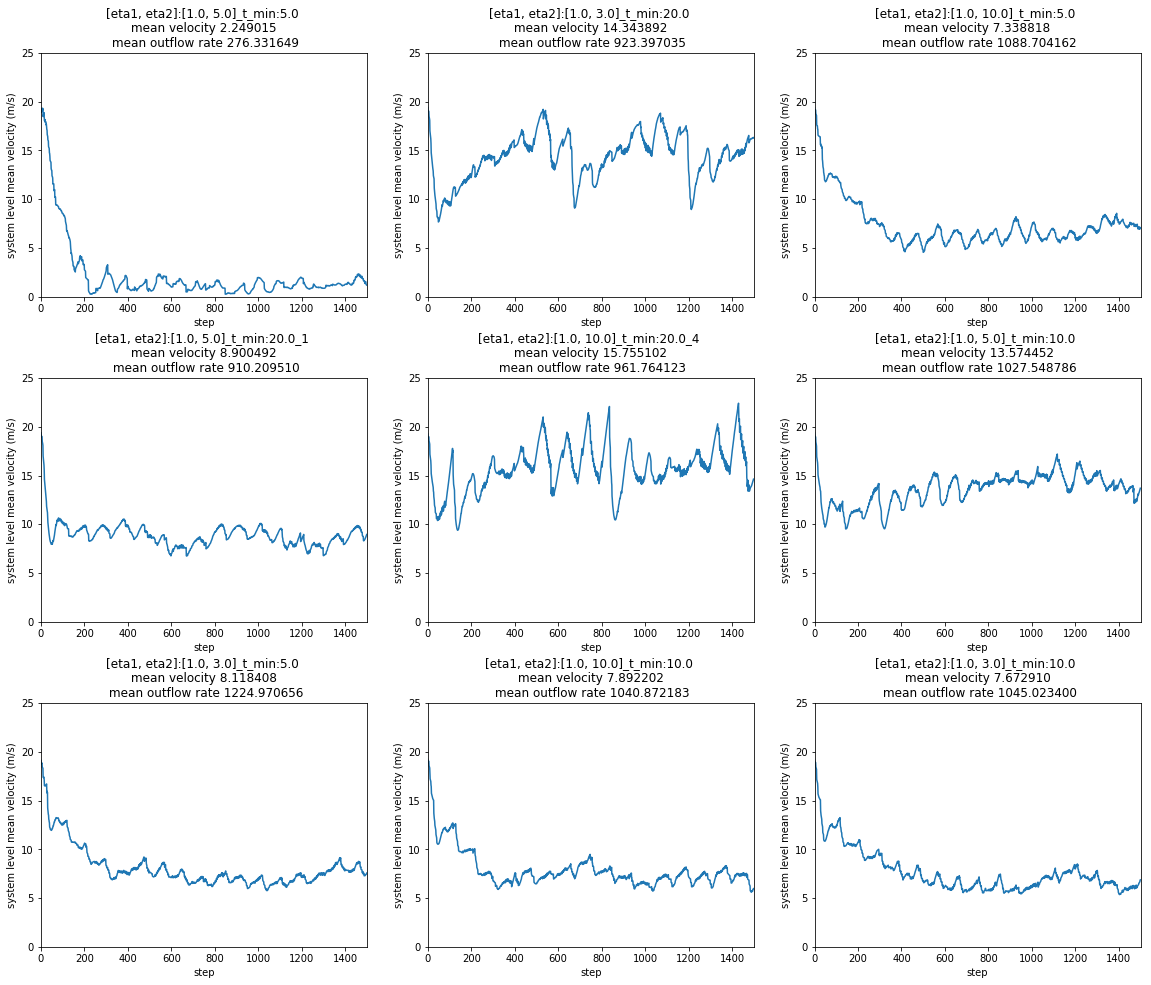

In [3]:
num_exp = len(results)
ncols = math.ceil(math.sqrt(num_exp))
nrows = math.ceil(num_exp / ncols)
vel_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
vel_fig.tight_layout(h_pad=8.0, w_pad=3.0)

for i, item in enumerate(results.items()):
    key, value = item
    vel = results[key]['mean_vel']
    outflow = results[key]['outflow']
    col = math.floor(i/ncols)
    row = i%ncols
    axes[col, row].plot(vel)
    axes[col, row].set_ylabel('system level mean velocity (m/s)')
    axes[col, row].set_xlabel('step')
    title = key + ' \n mean velocity {:3f}'.format(np.mean(vel))
    title = title + ' \n mean outflow rate {:3f}'.format(np.mean(outflow))
    axes[col, row].set_title(title)
    axes[col, row].set_xlim([0, len(vel)])
    axes[col, row].set_ylim([0, 25])
plt.subplots_adjust(top=0.8)

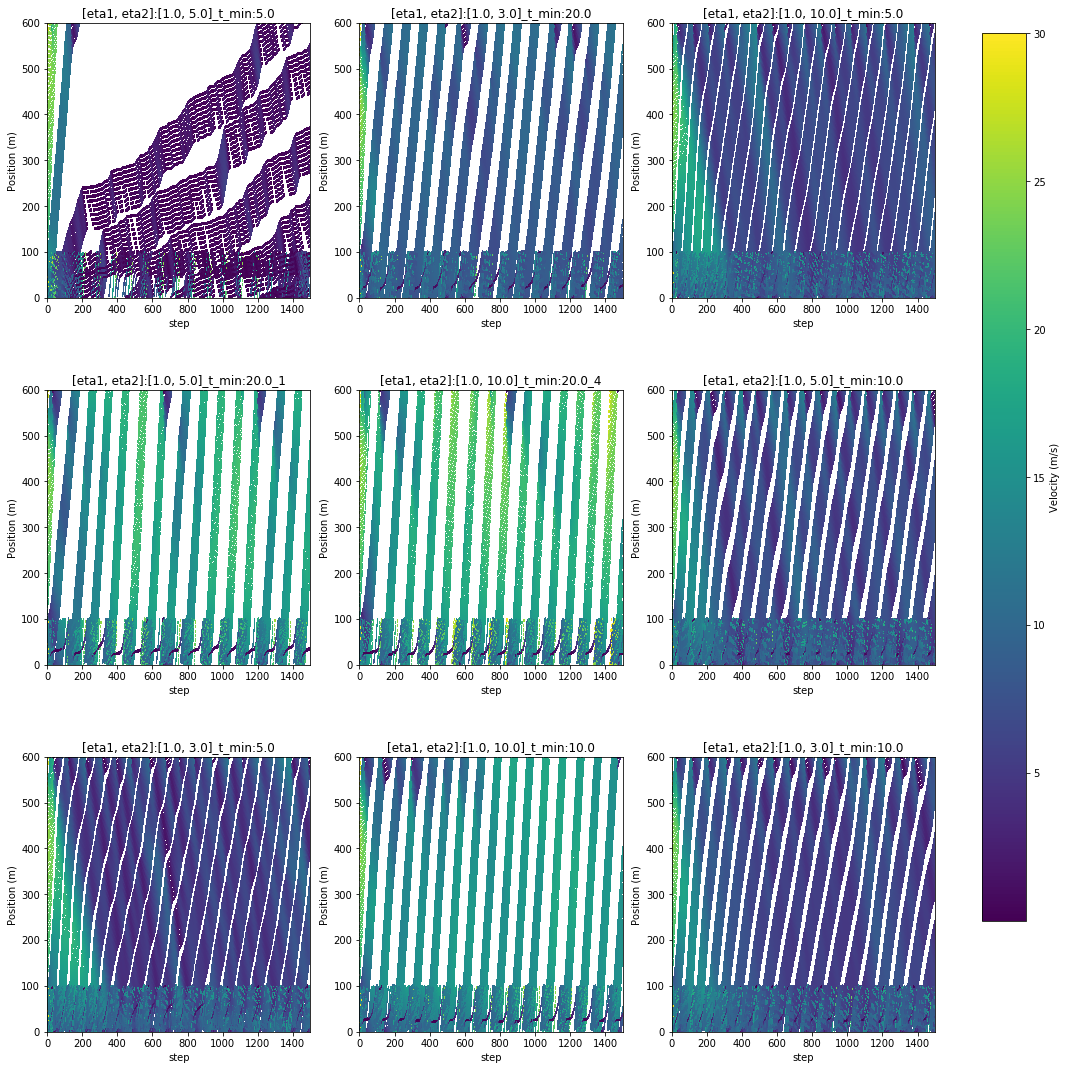

In [4]:
num_exp = len(results)
ncols = math.ceil(math.sqrt(num_exp))
nrows = math.ceil(num_exp / ncols)
space_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
space_fig.tight_layout(h_pad=8.0, w_pad=3.0)

for i, item in enumerate(results.items()):
    key, value = item
    vel_map = results[key]['vel_map']
    x = np.arange(int(env.env_params.horizon))
    y = np.arange(0, int(left_length), step=0.1)
    xx, yy = np.meshgrid(x, y)
    im = axes[i%nrows, int(i/ncols)].pcolormesh(xx, yy, vel_map.T)
    col = math.floor(i/ncols)
    row = i%ncols
    axes[col, row].set_ylabel('Position (m)')
    axes[col, row].set_xlabel('step')
    title = key
    axes[col, row].set_title(title)

clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)

clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
plt.subplots_adjust(top=0.9, right=0.8)

In [5]:
# save figures
filename = 'compare_results' + '.png'
vel_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/mean_velocity/'
space_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/space_time_diagram/'
os.makedirs(vel_dir, exist_ok=True)
os.makedirs(space_dir, exist_ok=True)

vel_fig.savefig(vel_dir + filename)
space_fig.savefig(space_dir + filename)